# 3. Running on IBM Q

Author : [Gwonhak Lee](https://github.com/snow0369) (gwonhak@gmail.com)

-----


In [16]:
from qiskit import IBMQ, QuantumRegister, QuantumCircuit, ClassicalRegister, transpile
from qiskit.tools import backend_overview, backend_monitor
from qiskit.providers.ibmq.job import job_monitor
from qiskit.quantum_info import hellinger_fidelity
from qiskit.providers.ibmq import IBMQAccountCredentialsNotFound
from qiskit.providers.aer import AerProvider
from qiskit.tools.visualization import plot_gate_map

In [2]:
token = 'f5876d2c6ea00ce4cefe8fcf6324956e042cd2a7cd57f6efc1e7ba38727964f10cef560830337f64c1de3743c420c1b23ded52bc01b197c6d8ce96394f13f1e0'# Input token here
try:
    IBMQ.disable_account()
except IBMQAccountCredentialsNotFound:
    pass
IBMQ.enable_account(token)

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
backend_overview()

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 0              Pending Jobs: 100            Pending Jobs: 64
Least busy:   True           Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      181.6          Avg. T1:      89.8           Avg. T1:      88.7
Avg. T2:      58.3           Avg. T2:      109.8          Avg. T2:      108.8



ibmq_lima                    ibmq_bogota                  ibmq_santiago
---------                    -----------                  -------------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 1              Pending Jobs: 3              Pending Jobs: 105
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True          

In [4]:
IBMQ_provider = IBMQ.get_provider()
ibmq_manila_backend = IBMQ_provider.get_backend('ibmq_manila')
backend_monitor(ibmq_manila_backend)

ibmq_manila
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 0
    backend_version: 1.0.5
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
    local: False
    simulator: False
    pulse_num_channels: 9
    dt: 0.2222222222222222
    max_shots: 8192
    uchannels_enabled: True
    description: 5 qubit device
    measure_esp_enabled: False
    multi_meas_enabled: True
    u_channel_lo: [[{'q': 1, 'scale': (1+0j)}], [{'q': 0, 'scale': (1+0j)}], [{'q': 2, 'scale': (1+0j)}], [{'q': 1, 'scale': (1+0j)}], [{'q': 3, 'scale': (1+0j)}], [{'q': 2, 'scale': (1+0j)}], [{'q': 4, 'scale': (1+0j)}], [{'q': 3, 'scale': (1+0j)}]]
    meas_levels: [1, 2]
    meas_lo_range: [[6.663214088, 7.663214088], [6.7833221550000005, 7.7833221550000005], [6.7189281020000005, 7.7189281020000005], [6.6101423420000005, 7.6101423420000005], [6.846997692, 7.846997692]]
    max_experiments: 75
    n_registers: 1
    url: None
    meas_kernels: ['hw_qmfk']
 

![ibmq_manila_config](./figures/ibmq_manila.jpg)

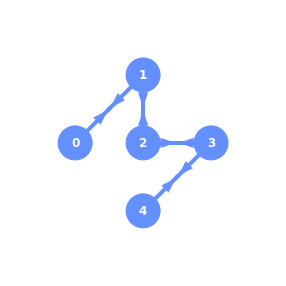

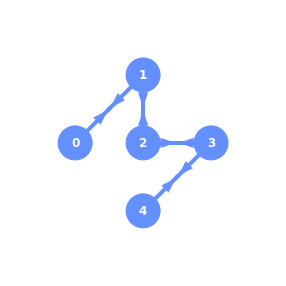

In [18]:
plot_gate_map(ibmq_manila_backend, plot_directed=True)

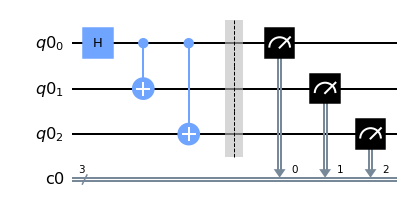

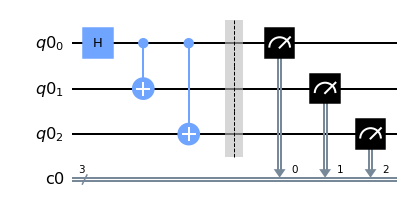

In [5]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
ghz3 = QuantumCircuit(qr, cr)
ghz3.h(qr[0])
ghz3.cx(qr[0], qr[1])
ghz3.cx(qr[0], qr[2])
ghz3.barrier()
ghz3.measure(qr, cr)

ghz3.draw('mpl')

In [6]:
job_exp = ibmq_manila_backend.run(ghz3, shots=2048)
job_monitor(job_exp) # An error must be raised here.

Job Status: job incurred error


In [7]:
print(ibmq_manila_backend.configuration().basis_gates)

['id', 'rz', 'sx', 'x', 'cx', 'reset']


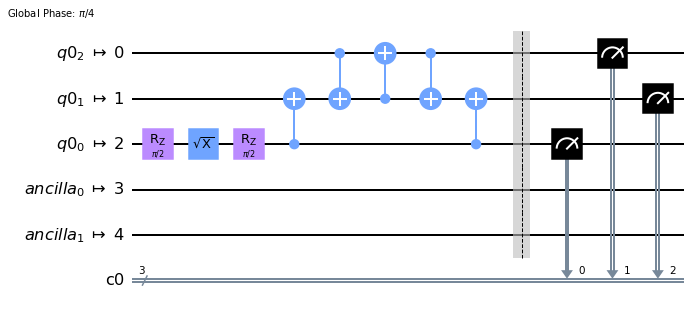

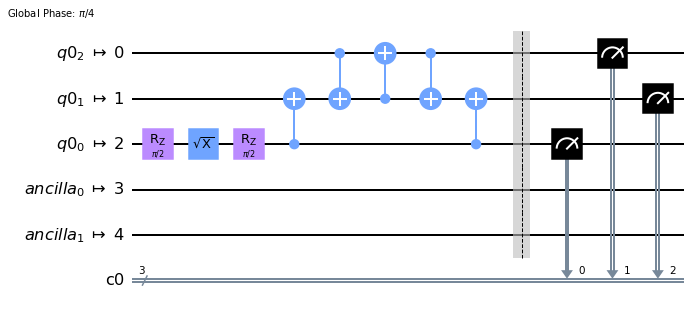

In [8]:
transpiled_circuit = transpile(ghz3, backend=ibmq_manila_backend)
transpiled_circuit.draw('mpl')

In [9]:
job_exp = ibmq_manila_backend.run(transpiled_circuit, shots=2048)
job_monitor(job_exp) # An error must be raised here.

Job Status: job has successfully run


In [11]:
noisy_counts = job_exp.result().get_counts()

In [15]:
qasm_backend = AerProvider().get_backend('qasm_simulator')
job_ideal = qasm_backend.run(ghz3, shots=2048)
ideal_counts = job_ideal.result().get_counts()

print(hellinger_fidelity(noisy_counts, ideal_counts))


0.8828768337270209
